# Analyzing the embeddings

This notebook pretends to analyze the output of the get_embeddings script evaluating them with a dataset

In [1]:
# Library imports
import os
import glob

import pandas as pd
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
from sentence_transformers import util

In [ ]:
# Global variables
MODELS = ['all-MiniLM-L6-v2', 'multi-qa-mpnet-base-dot-v1', 'Qwen/Qwen3-Embedding-0.6B', 'Qwen/Qwen3-Embedding-4B', 'Qwen/Qwen3-Embedding-8B', 'Qwen3-Embedding-0.6B-Q8_0', 'Qwen3-Embedding-0.6B-f16', 'Qwen3-Embedding-4B-Q4_K_M', 'Qwen3-Embedding-4B-f16', 'Qwen3-Embedding-8B-Q4_K_M', 'Qwen3-Embedding-8B-f16']
DATA_PATH = '../data'
DATA_EMBEDDINGS_PATH = f'../data_embeddings'
DATASET_EMBEDDINGS_PATH = f'../dataset_embeddings'
DATASET_NAME = 'Rivert97/ug-normativity'
RESULTS_DIR = '../results'

# Other variables
k = 5
file_excludes = []
score_metric = 'dot' # dot, cos

In [3]:
def load_csv_data(data_embeddings_dirname, dataset_embeddings_dirname):
    all_data = []
    all_embeddings = []
    all_questions_embeddings = []

    # Loading the data
    for data_filename in glob.glob(os.path.join(DATA_PATH, '*.csv')):
        embeddings_filename = os.path.join(data_embeddings_dirname, os.path.split(data_filename)[1])
        questions_filename = os.path.join(dataset_embeddings_dirname, os.path.split(data_filename)[1])

        if not os.path.exists(questions_filename):
            print(f"Ignoring file {data_filename}")
            file_excludes.append(os.path.splitext(os.path.split(data_filename)[1])[0])
            continue

        if os.path.splitext(os.path.split(data_filename)[1])[0] in file_excludes:
            continue

        data = pd.read_csv(data_filename, sep=',', index_col=0)
        embeddings = pd.read_csv(embeddings_filename, sep=',', index_col=0)
        questions_embeddings = pd.read_csv(questions_filename, sep=',', index_col=0)

        all_data.append(data)
        all_embeddings.append(embeddings)
        all_questions_embeddings.append(questions_embeddings)

    data = pd.concat(all_data, ignore_index=True)
    embeddings = pd.concat(all_embeddings, ignore_index=True)
    questions_embeddings = pd.concat(all_questions_embeddings)

    return data, embeddings, questions_embeddings

In [4]:
def find_questions_related_chunks(dataset, questions_embeddings, data, embeddings):
    # For each question find its chunk
    questions = []

    for question in dataset:
        if question['title'] in file_excludes:
            continue

        tmp_question = {
            'question': question,
            'question_embeddings': questions_embeddings.loc[question['id']].values,
            'chunk_idx': [],
            'chunk': [],
            'chunk_embeddings': [],
        }

        for path, chunks in data.loc[data['document_name'] == question['title']].groupby('path'):
            if path.lower().endswith(question['context'].lower().strip()):
                for chunk_idx, chunk in chunks.sort_values('num').iterrows():
                    tmp_question['chunk_idx'].append(chunk_idx)
                    tmp_question['chunk'].append(chunk)
                    tmp_question['chunk_embeddings'].append(embeddings.loc[chunk_idx].values)

        if tmp_question['chunk_idx']:
            questions.append(tmp_question)

    return questions

In [5]:
def get_scores_from_questions_to_answers(questions):
    # Analyzing scores between questions and its chunks
    scores = []
    for question in questions:
        for chunk_embeddings in question['chunk_embeddings']:
            if score_metric == 'cos':
                score = 1.0 - np.dot(question['question_embeddings'], chunk_embeddings)/(np.linalg.norm(question['question_embeddings'])*np.linalg.norm(chunk_embeddings))
                scores.append(score)
            else:
                score = util.dot_score(question['question_embeddings'], chunk_embeddings)
                scores.append(score[0][0])

    return scores

In [6]:
def get_top_k_scores_info(questions, data, embeddings):
    # Analyzing score from each question to its K neighbors
    top_k_info = {
        'scores': [],
        'scores_mean': [],
        'embeddings_idx': {},
    }
    for question in questions:
        if score_metric == 'cos':
            scores = 1.0 - np.dot(question['question_embeddings'], embeddings.values.T)/(np.linalg.norm(question['question_embeddings'])*np.linalg.norm(embeddings.values, axis=1))
            reversed_sort = False
        else:
            scores = util.dot_score(question['question_embeddings'], embeddings.values)[0].tolist()
            reversed_sort = True
        doc_score_pairs = list(zip(data.index.tolist(), scores))

        try:
            doc_score_pairs = sorted(doc_score_pairs, key=lambda x: x[1], reverse=reversed_sort)
        except ValueError:
            print(doc_score_pairs)

        dist = [d[1] for d in doc_score_pairs[:k]]
        idx = [d[0] for d in doc_score_pairs[:k]]

        top_k_info['scores'].extend(dist)
        top_k_info['scores_mean'].append(np.mean(dist))
        top_k_info['embeddings_idx'][question['question']['id']] = idx

    return top_k_info

In [7]:
def get_presence_percentage_in_top_k(questions, top_k_info):
    # Analyzing percentaje of answers present in K nearest neighbors
    count_in_top_k = 0
    for question in questions:
        top_k_idx = top_k_info['embeddings_idx'][question['question']['id']]
        for chunk_idx in question['chunk_idx']:
            if chunk_idx in top_k_idx:
                count_in_top_k += 1/len(question['chunk_idx'])

    presence_top_k = count_in_top_k/len(questions)

    return presence_top_k

In [8]:
def get_f1_metrics_at_k(questions, data, top_k_info):
    # Obtaining F1@k
    metrics = {
        'precisions': np.zeros((len(questions),), dtype=np.float32),
        'recalls': np.zeros((len(questions),), dtype=np.float32),
        'f1s': np.zeros((len(questions),), dtype=np.float32),
    }

    for q_idx, question in enumerate(questions):
        n_relevant = 0
        top_k_idx = top_k_info['embeddings_idx'][question['question']['id']]
        all_relevant = data[(data['document_name'] == question['question']['title']) & (data['parent'] == question['question']['context'].split('/')[-1])]

        for idx in top_k_idx:
            if data.loc[idx, 'path'].lower().endswith(question['question']['context'].lower()):
                n_relevant += 1

        precision = n_relevant/k
        recall = n_relevant/len(all_relevant) if len(all_relevant) > 0 else 0
        f1 = (2*precision*recall)/(precision+recall) if precision+recall > 0 else 0

        metrics['precisions'][q_idx] = precision
        metrics['recalls'][q_idx] = recall
        metrics['f1s'][q_idx] = f1

    return metrics['precisions'].mean(), metrics['recalls'].mean(), metrics['f1s'].mean()

In [9]:
def update_csv_data(filename, new_data, axis=0):
    if os.path.exists(filename):
        prev_df = pd.read_csv(filename, sep=',', index_col=0)
        if axis == 0:
            if set(new_data.index).intersection(set(prev_df.index)):
                for idx in new_data.index:
                    prev_df.loc[idx] = new_data.loc[idx]
                updated_df = prev_df
            else:
                updated_df = pd.concat([prev_df, new_data], ignore_index=False, axis=axis)
        else:
            if set(new_data.columns).intersection(set(prev_df.columns)):
                for col in new_data.columns:
                    prev_df[col] = new_data[col]
                updated_df = prev_df
            else:
                updated_df = pd.concat([prev_df, new_data], ignore_index=False, axis=axis)
    else:
        updated_df = new_data

    updated_df.to_csv(filename, sep=',')

In [10]:
def get_presence_percentage_in_top_k_by_file(questions, top_k_info, document_list, model_id):
    # Analyzing percentaje of answers present in K nearest neighbors
    presence_top_k = []
    for file in document_list:
        if file in file_excludes:
            continue

        count_in_top_k = 0
        total_questions_count = 0
        for question in filter(lambda q: q['question']['title'] == file, questions):
            top_k_idx = top_k_info['embeddings_idx'][question['question']['id']]
            for chunk_idx in question['chunk_idx']:
                if chunk_idx in top_k_idx:
                    count_in_top_k += 1/len(question['chunk_idx'])
            total_questions_count += 1

        presence = count_in_top_k/total_questions_count
        presence_top_k.append(presence)

    return pd.DataFrame({model_id: presence_top_k}, index=document_list)

In [11]:
def get_f1_metrics_at_k_by_file(questions, data, top_k_info, document_list, model_id):
    # Obtaining F1@k
    mean_precisions = []
    mean_recalls = []
    mean_f1s = []
    for file in document_list:
        if file in file_excludes:
            continue

        file_questions = list(filter(lambda q: q['question']['title'] == file, questions))

        metrics = {
            'precisions': np.zeros((len(file_questions),), dtype=np.float32),
            'recalls': np.zeros((len(file_questions),), dtype=np.float32),
            'f1s': np.zeros((len(file_questions),), dtype=np.float32),
        }
        for q_idx, question in enumerate(file_questions):
            n_relevant = 0
            top_k_idx = top_k_info['embeddings_idx'][question['question']['id']]
            all_relevant = data.loc[(data['document_name'] == question['question']['title']) & (data['path'].str.lower().str.endswith(question['question']['context'].lower()))]

            for idx in top_k_idx:
                chunk = data.loc[idx]
                if (chunk['document_name'] == question['question']['title'] and
                    chunk['path'].lower().endswith(question['question']['context'].lower())):
                    n_relevant += 1

            precision = n_relevant/k
            recall = n_relevant/len(all_relevant) if len(all_relevant) > 0 else 0
            f1 = (2*precision*recall)/(precision+recall) if precision+recall > 0 else 0

            metrics['precisions'][q_idx] = precision
            metrics['recalls'][q_idx] = recall
            metrics['f1s'][q_idx] = f1

        mean_precision = metrics['precisions'].mean()
        mean_recall = metrics['recalls'].mean()
        mean_f1 = metrics['f1s'].mean()

        mean_precisions.append(mean_precision)
        mean_recalls.append(mean_recall)
        mean_f1s.append(mean_f1)

    return pd.DataFrame({f'{model_id} precision': mean_precisions, f'{model_id} recall': mean_recalls, f'{model_id} f1': mean_f1s}, index=document_list)

In [12]:
# Loading questions dataset
dataset = load_dataset(DATASET_NAME)
dataset = dataset['train']

In [13]:
dataset

Dataset({
    features: ['id', 'title', 'context', 'context_text', 'additional_context', 'question', 'answers'],
    num_rows: 1829
})

In [14]:
all_models_scores = {}
all_models_top_k_info = {}
all_models_full_metrics = []
all_models_presence_by_file = []
all_models_metrics_by_file = []
for model_id in MODELS:
    print(f"Procesando {model_id}")
    data, embeddings, questions_embeddings = load_csv_data(os.path.join(DATA_EMBEDDINGS_PATH, model_id), os.path.join(DATASET_EMBEDDINGS_PATH, model_id))
    questions = find_questions_related_chunks(dataset, questions_embeddings, data, embeddings)
    scores = get_scores_from_questions_to_answers(questions)
    top_k_info = get_top_k_scores_info(questions, data, embeddings)
    presence = get_presence_percentage_in_top_k(questions, top_k_info)
    precision, recall, f1 = get_f1_metrics_at_k(questions, data, top_k_info)

    full_metrics = pd.DataFrame({'% presence': [presence], 'precision': [precision], 'recall': [recall], 'f1': [f1]}, index=[model_id])
    full_metrics_filename = os.path.join(RESULTS_DIR, f'mean_metrics_top_{k}.csv')
    update_csv_data(full_metrics_filename, full_metrics)

    presence_by_file = get_presence_percentage_in_top_k_by_file(questions, top_k_info, data['document_name'].unique(), model_id)

    presence_by_file_filename = os.path.join(RESULTS_DIR, f'presence_top_{k}.csv')
    update_csv_data(presence_by_file_filename, presence_by_file, axis=1)

    metrics_by_file = get_f1_metrics_at_k_by_file(questions, data, top_k_info, data['document_name'].unique(), model_id)

    metrics_by_file_filename = os.path.join(RESULTS_DIR, f'metrics_top_{k}.csv')
    update_csv_data(metrics_by_file_filename, metrics_by_file, axis=1)

    all_models_scores[model_id] = scores
    all_models_top_k_info[model_id] = top_k_info
    all_models_full_metrics.append(full_metrics)
    all_models_presence_by_file.append(presence_by_file)
    all_models_metrics_by_file.append(metrics_by_file)

Procesando Qwen/Qwen3-Embedding-0.6B
Ignoring file ../data/modelo-educativo-de-la-universidad-de-guanajuato-y-su-modelo-academico-ug.csv
Procesando Qwen3-Embedding-0.6B-Q8_0
Ignoring file ../data/modelo-educativo-de-la-universidad-de-guanajuato-y-su-modelo-academico-ug.csv


Qwen/Qwen3-Embedding-0.6B
Scores top-5
Min:  0.2993897120118338
Max:  0.9496117893084415
Mean:  0.5986223438643133
Scores top-5 mean
Min:  0.33700893018396016
Max:  0.8479607908755528
Mean:  0.5986223438643133

Qwen3-Embedding-0.6B-Q8_0
Scores top-5
Min:  3273.4990766011315
Max:  12937.981380392355
Mean:  7392.8303595686475
Scores top-5 mean
Min:  3908.645005502037
Max:  11426.927303388682
Mean:  7392.830359568648



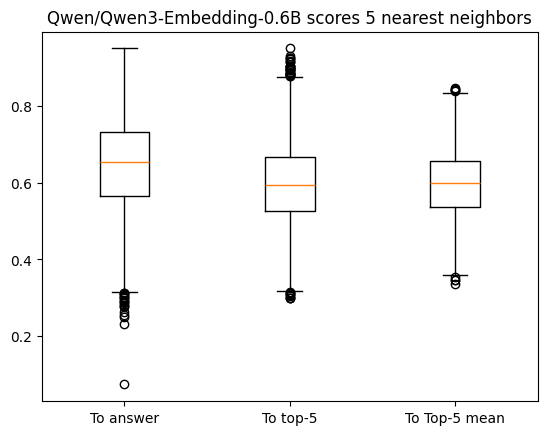

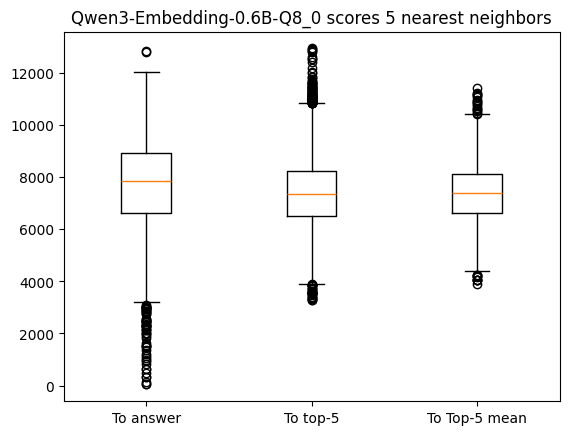

In [15]:
save_img_dir = os.path.join(RESULTS_DIR, 'images', f'top_{k}')
os.makedirs(save_img_dir, exist_ok=True)

for model_id in MODELS:
    plt.figure()
    plt.title(f"{model_id} scores {k} nearest neighbors")
    plt.boxplot((all_models_scores[model_id], all_models_top_k_info[model_id]['scores'], all_models_top_k_info[model_id]['scores_mean']), tick_labels=['To answer', f'To top-{k}', f'To Top-{k} mean'])
    plt.savefig(os.path.join(save_img_dir, f'{model_id.split('/')[-1]}.png'))
    print(model_id)
    print(f"Scores top-{k}")
    print("Min: ", min(all_models_top_k_info[model_id]['scores']))
    print("Max: ", max(all_models_top_k_info[model_id]['scores']))
    print("Mean: ", np.mean(all_models_top_k_info[model_id]['scores']))
    print(f"Scores top-{k} mean")
    print("Min: ", min(all_models_top_k_info[model_id]['scores_mean']))
    print("Max: ", max(all_models_top_k_info[model_id]['scores_mean']))
    print("Mean: ", np.mean(all_models_top_k_info[model_id]['scores_mean']))
    print('')

In [16]:
final_full_metrics = pd.concat(all_models_full_metrics)
final_full_metrics

,% presence,precision,recall,f1
Qwen/Qwen3-Embedding-0.6B,0.833516,0.184144,0.894478,0.299201
Qwen3-Embedding-0.6B-Q8_0,0.771733,0.173537,0.842264,0.281601


In [17]:
final_presence_by_file = pd.concat(all_models_presence_by_file, ignore_index=False, axis=1)
final_presence_by_file

,Qwen/Qwen3-Embedding-0.6B,Qwen3-Embedding-0.6B-Q8_0
ley-organica-de-la-universidad-de-guanajuato,0.807018,0.745614
reglamento-del-personal-academico-de-la-universidad-de-guanajuato,0.876068,0.811966
reglamento-de-distinciones-universitarias-de-la-universidad-de-guanajuato,0.929825,0.894737
reglamento-de-la-junta-directiva-de-la-universidad-de-guanajuato,0.924242,0.924242
reglamento-para-la-incorporacion-al-regimen-academico-de-la-universidad-de-guanajuato,0.936508,0.873016
reglamento-interno-del-patronato-de-la-universidad-de-guanajuato,0.837838,0.797297
reglamento-de-quienes-integran-la-orquesta-sinfonica-de-la-universidad-de-guanajuato_2021-2023,0.873239,0.690141
reglamento-academico-de-la-universidad-de-guanajuato,0.943925,0.906542
codigo-de-etica-de-las-personas-servidoras-publicas-universidad-de-gunajuato,0.576923,0.384615
reglamento-de-la-defensoria-de_los-derechos-humanos-en-el-entorno-universitario-de-la-universidad-de-guanajuato,0.860215,0.860215


In [18]:
final_metrics_by_file = pd.concat(all_models_metrics_by_file, ignore_index=False, axis=1)
final_metrics_by_file

,Qwen/Qwen3-Embedding-0.6B precision,Qwen/Qwen3-Embedding-0.6B recall,Qwen/Qwen3-Embedding-0.6B f1,Qwen3-Embedding-0.6B-Q8_0 precision,Qwen3-Embedding-0.6B-Q8_0 recall,Qwen3-Embedding-0.6B-Q8_0 f1
ley-organica-de-la-universidad-de-guanajuato,0.161404,0.807018,0.269006,0.149123,0.745614,0.248538
reglamento-del-personal-academico-de-la-universidad-de-guanajuato,0.175214,0.876068,0.292023,0.162393,0.811966,0.270655
reglamento-de-distinciones-universitarias-de-la-universidad-de-guanajuato,0.185965,0.929825,0.309942,0.178947,0.894737,0.298246
reglamento-de-la-junta-directiva-de-la-universidad-de-guanajuato,0.184849,0.924242,0.308081,0.184849,0.924242,0.308081
reglamento-para-la-incorporacion-al-regimen-academico-de-la-universidad-de-guanajuato,0.187302,0.936508,0.312169,0.174603,0.873016,0.291005
reglamento-interno-del-patronato-de-la-universidad-de-guanajuato,0.172973,0.837838,0.285714,0.162162,0.797297,0.268983
reglamento-de-quienes-integran-la-orquesta-sinfonica-de-la-universidad-de-guanajuato_2021-2023,0.174648,0.873239,0.291080,0.138028,0.690141,0.230047
reglamento-academico-de-la-universidad-de-guanajuato,0.188785,0.943925,0.314642,0.181308,0.906542,0.302181
codigo-de-etica-de-las-personas-servidoras-publicas-universidad-de-gunajuato,0.115385,0.576923,0.192308,0.076923,0.384615,0.128205
reglamento-de-la-defensoria-de_los-derechos-humanos-en-el-entorno-universitario-de-la-universidad-de-guanajuato,0.172043,0.860215,0.286738,0.172043,0.860215,0.286738
